In [2]:
from pyquaternion import Quaternion
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import math
import scipy.io
import sys
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import csv

In [4]:
qa = Quaternion(1,0,0,0)
a1,a2,a3,a4 = qa
print(a1,a2,a3,a4)
# np.set_printoptions(linewidth=np.inf)
np.set_printoptions(precision=5)

1.0 0.0 0.0 0.0


In [7]:
imu_data_orig = scipy.io.loadmat('./ExampleData.mat')

In [9]:
print(imu_data_orig['Accelerometer'].shape,imu_data_orig['Gyroscope'].shape,imu_data_orig['Gyroscope'].shape[0])

(6959, 3) (6959, 3) 6959


In [10]:
print(np.amax(imu_data_orig['Gyroscope']),np.amax(imu_data_orig['Accelerometer'][:100]))

234.375 1.032227


In [11]:
np.set_printoptions(threshold=sys.maxsize)
print(imu_data_orig['Gyroscope'][:20])

[[-0.9375 -1.25    0.875 ]
 [-0.9375 -1.25    0.875 ]
 [-0.9375 -1.875   0.25  ]
 [-1.3125 -2.      0.125 ]
 [-1.75   -2.125   0.    ]
 [-1.5625 -2.3125 -0.1875]
 [-1.25   -2.1875 -0.0625]
 [-1.     -1.9375 -0.0625]
 [-0.8125 -1.6875  0.0625]
 [-0.625  -1.3125  0.    ]
 [-0.875  -1.0625  0.375 ]
 [-0.8125 -0.625   0.4375]
 [-1.1875 -0.625   0.625 ]
 [-1.4375 -0.6875  0.625 ]
 [-1.625  -1.0625  0.8125]
 [-1.625  -1.      0.6875]
 [-2.     -0.875   0.625 ]
 [-2.6875 -1.1875  0.625 ]
 [-2.875  -1.3125  0.625 ]
 [-3.125  -1.375   0.875 ]]


In [12]:
qa = Quaternion(1,0,0,0)
print(qa)
w,x,y,z = qa
print(w,x,y,z)

1.000 +0.000i +0.000j +0.000k
1.0 0.0 0.0 0.0


In [13]:
def quat_to_euler(q):
    w,x,y,z = q
#     roll  = math.atan2(2*y*w - 2*x*z, 1 - 2*y*y - 2*z*z)
#     pitch = math.atan2(2*x*w - 2*y*z, 1 - 2*x*x - 2*z*z)
#     yaw = math.asin (2*x*y + 2*z*w)
    R11 = 2*(w**2)-1+2*(x**2)
    R21 = 2*(x*y-w*z)
    R31 = 2*(x*z+w*y)
    R32 = 2*(y*z-w*x)
    R33 = 2*(w**2)-1+2*(z**2)
    
    phi = math.atan2(R32, R33 )*(180/np.pi);
    theta = -math.atan(R31/math.sqrt(1-R31**2) )*(180/np.pi);
    psi = math.atan2(R21, R11 )*(180/np.pi);
    return phi, theta, psi

In [14]:
def quaternConj(q):
    w,x,y,z = q
    q_conj = np.array([w,-x,-y,-z])
    return q_conj

In [15]:
class madgwick:
    def __init__(self,q=Quaternion(1,0,0,0),beta = 0.1,invSampleFreq = 1.0/256.0 ):
        self.beta = beta
        w,x,y,z = q 
        self.q_new = np.array([[w],[x],[y],[z]])
        self.invSampleFreq = invSampleFreq
        self.counter = 0
    
    def imu_update(self,acc,gyro,q_est):
        '''
        INPUT:
            acc= numpy array of length 3 having three accelerations ax, ay, az
            gyro= numpy array of length 3 having three angular accelerations gx, gy, gz

        Output:
            Pose in quaternion
        '''

        if(not(np.linalg.norm(acc)==0)):
            #normalize acc data
            acc = np.divide(acc,np.linalg.norm(acc))
            ax = acc[0]
            ay = acc[1]
            az = acc[2]
            q1,q2,q3,q4 = q_est
#             print "incomming q = ",q_est
            f = np.array([2*(q2*q4-q1*q3) - ax,
                          2*(q1*q2+q3*q4) - ay,
                          2*(0.5 - q2**2 - q3**2) - az])
#             print "f =",f
            J = np.matrix([[-2*q3, 2*q4, -2*q1, 2*q2],
                           [2*q2, 2*q1, 2*q4, 2*q3],
                           [0, -4*q2, -4*q3, 0]])
#             print "J =",J
            step = np.array(np.matmul(J.T,f))
#             print "step = ", step,"type = ", type(step),"shape = ", np.shape(step)

            step = np.divide(step,np.linalg.norm(step))
#             print "step norm = ",step
            q_del = self.beta*step
#             print "q_del = ", q_del," qdel shape = ",np.shape(q_del)
#             print "gyro_data",gyro,"gyro to quat ", Quaternion(0,gyro[0],gyro[1],gyro[2])
            gyro_quat = Quaternion(0,gyro[0],gyro[1],gyro[2])
    #         q_dot = 0.5*quaternion_multiply(q_est, gyro_quat)
#             print "q_est = ",q_est.q
#             print "gyro_quat = ",gyro_quat
            q_dot_ob = (q_est*gyro_quat)
#             print "qdot mul = ", q_dot_ob
            q_dot = 0.5*q_dot_ob.q
            q_dot = np.reshape(q_dot,(4,1))
#             print "qdot  = ", q_dot

        #fuse
        q_dot_est_new = q_dot-q_del
#         print "q_dot_final = ", q_dot_est_new
        self.q_new += q_dot_est_new*self.invSampleFreq
        self.q_new = np.divide(self.q_new,np.linalg.norm(self.q_new))
        np.set_printoptions(precision=5)
#         print "q_new = ", np.reshape(self.q_new,(4,1))
#         self.q_new = Quaternion(self.q_new)
        
#         self.q_new = self.q_new.normalised
#         a1,a2,a3,a4=self.q_new
#         self.q_new = np.array([a1,a2,a3,a4])
        
        return np.reshape(self.q_new,(4,))

6958
6958


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

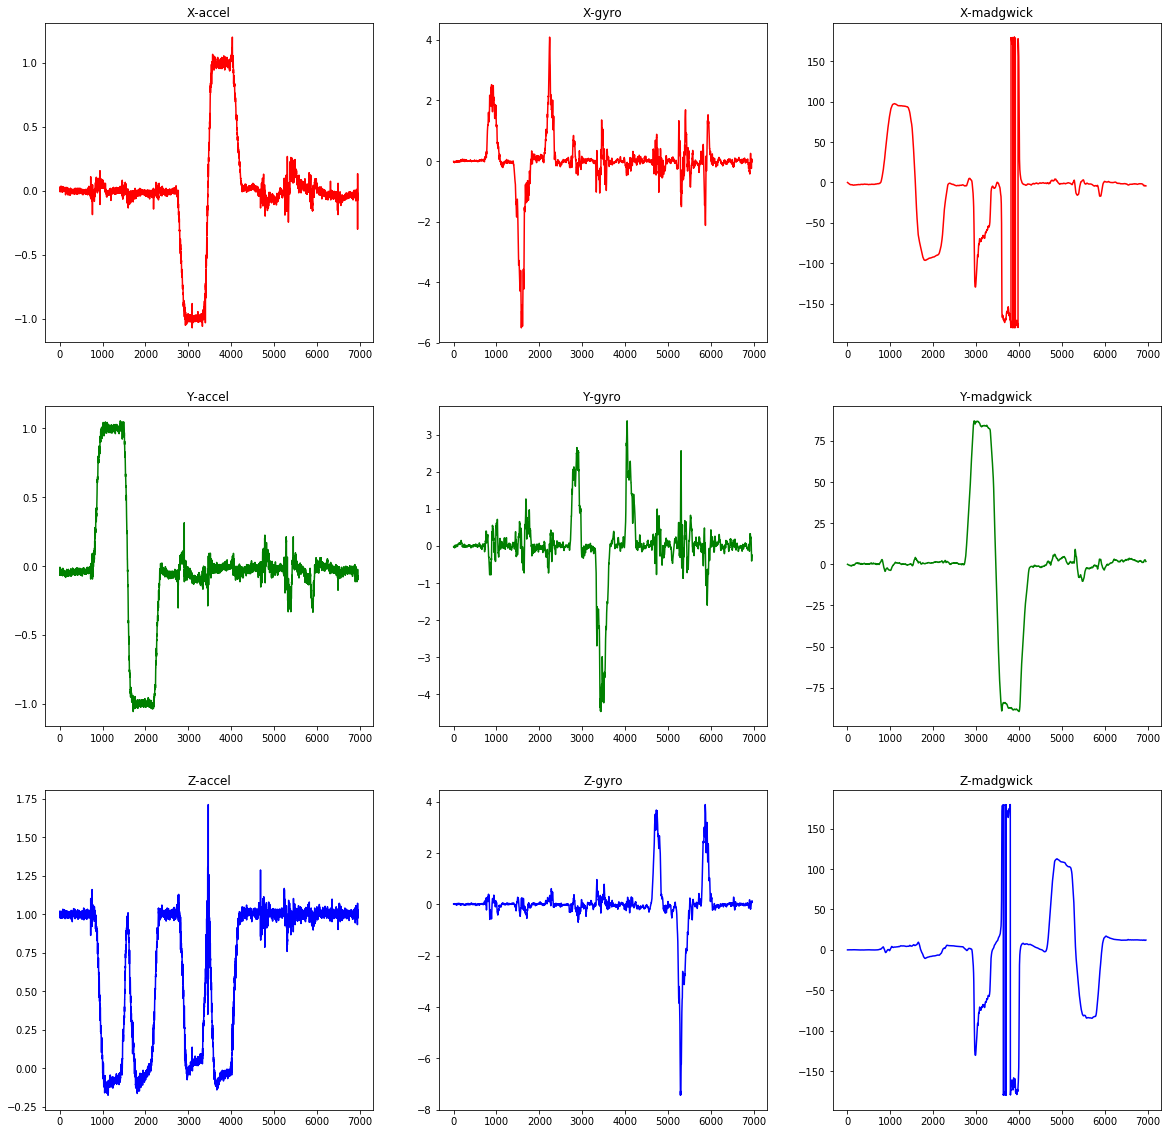

In [19]:
imu_data_orig = scipy.io.loadmat('./ExampleData.mat')
thresh = len(imu_data_orig['Accelerometer'])-1
print(thresh)
acc_all = imu_data_orig['Accelerometer']
gyro_all = imu_data_orig['Gyroscope']
q_est = Quaternion(1,0,0,0)
q_init = Quaternion(1,0,0,0)
angles = np.array([0,0,0])
mk=madgwick(q = q_init)
thresh = len(acc_all)-1
print(thresh)
# thresh = 100
i=0
employee_file = open('my_madwick.csv', mode='w')
quat_file  = open('quat_my_madwick.csv', mode='w')
employee_writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
quat_writer = csv.writer(quat_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
while i<=thresh:
    
#     print i+1
#     acc = acc_all[i]
    acc = np.reshape(acc_all[i], (3,1))
#     print "acc data = ",acc 
#     gyro = gyro_all[i]
    #print gyro, gyro.shape
    gyro = np.reshape(gyro_all[i], (3,1))
#     print "gyro data orig",gyro
    gyro*=(np.pi/180.0)
#     print "gyro data deg",gyro
#     imu_update_flag = mk.cal_bias_and_update(acc,gyro)
    
#     if(imu_update_flag):
    
    q = mk.imu_update(acc,gyro,q_est)
    
#     phi, thetha, psy = euler_angles
    phi,thetha,psy = quat_to_euler(quaternConj(q))
    
    employee_writer.writerow([phi,thetha,psy])
    quat_writer.writerow([q[0],q[1],q[2],q[3]])
    temp = np.array([phi, thetha, psy])

    angles= np.vstack((angles,temp))
#     print "q = ",q
    q_est = Quaternion(q[0],q[1],q[2],q[3])
    i+=1
angles = angles[1:]
# print mk.return_num_ignored_samples
# num = mk.return_num_ignored_samples
# print num
num=0
acc_all = acc_all[num:]
gyro_all = gyro_all[num:]
t = np.linspace(1,int(acc_all.shape[0]),num = int(acc_all.shape[0]))
t_angles = np.linspace(1,int(angles.shape[0]),num = int(angles.shape[0]))
fig=plt.figure(1)
# plt.rcParams['figure.figsize'] = [10,10]
fig2=plt.figure(2)
# plt.rcParams['figure.figsize'] = [10,10]
plt.figure(figsize=(20,20))
a1 = plt.subplot(3,3,1)
plt.plot(t[:thresh],acc_all[:thresh,0],'r-')
a1.title.set_text('X-accel')

a2 = plt.subplot(3,3,2)
plt.plot(t[:thresh],gyro_all[:thresh,0],'r-')
a2.title.set_text('X-gyro')

# print t.shape,angles[:,0].shape

a3 = plt.subplot(3,3,3)
plt.plot(t_angles,angles[:,0],'r-')
a3.title.set_text('X-madgwick')


a4 = plt.subplot(3,3,4)
plt.plot(t[:thresh],acc_all[:thresh,1],'g-')
a4.title.set_text('Y-accel')

a5 = plt.subplot(3,3,5)
plt.plot(t[:thresh],gyro_all[:thresh,1],'g-')
a5.title.set_text('Y-gyro')

a6 = plt.subplot(3,3,6)
plt.plot(t_angles,angles[:,1],'g-')
a6.title.set_text('Y-madgwick')

a7 = plt.subplot(3,3,7)
plt.plot(t[:thresh],acc_all[:thresh,2],'b-')
a7.title.set_text('Z-accel')

a8 = plt.subplot(3,3,8)
plt.plot(t[:thresh],gyro_all[:thresh,2],'b-')
a8.title.set_text('Z-gyro')

a9 = plt.subplot(3,3,9)
plt.plot(t_angles,angles[:,2],'b-')
a9.title.set_text('Z-madgwick')

# plt.figure(figsize=(20,20))
# b1 = plt.subplot(2,2,1)
# plt.plot(t,angles[:,0],'r-')
# b1.title.set_text('X-madgwick')

# b2 =  plt.subplot(2,2,2)
# plt.plot(t,angles[:,1],'g-')
# b2.title.set_text('Y-madgwick')

# b3 = plt.subplot(2,2,3)
# plt.plot(t,angles[:,2],'b-')
# b3.title.set_text('Z-madgwick')

In [21]:
print(len(angles))

6959


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


<Figure size 432x288 with 0 Axes>

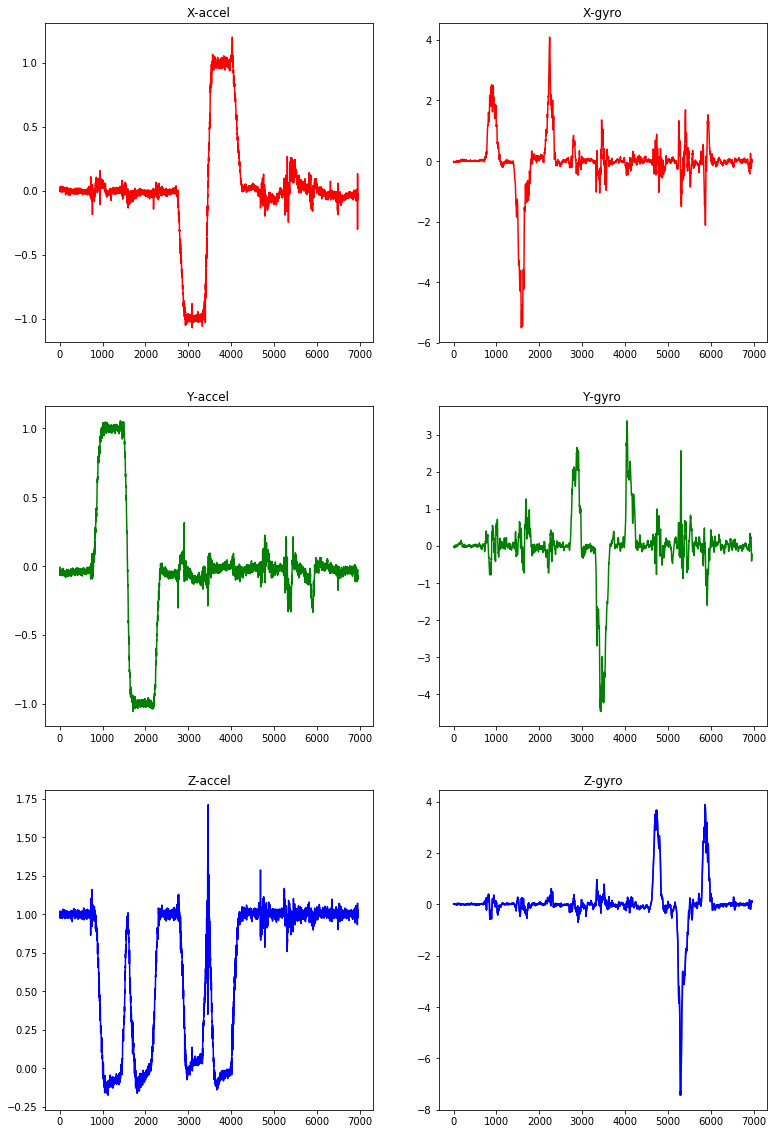

In [22]:
acc_all = imu_data_orig['Accelerometer']
gyro_all = imu_data_orig['Gyroscope']
t = np.linspace(1,int(acc_all.shape[0]),num = int(acc_all.shape[0]))

fig2=plt.figure(2)
# plt.rcParams['figure.figsize'] = [10,10]
plt.figure(figsize=(20,20))
a1 = plt.subplot(3,3,1)
plt.plot(t,acc_all[:,0],'r-')
a1.title.set_text('X-accel')

a2 = plt.subplot(3,3,2)
plt.plot(t,gyro_all[:,0],'r-')
a2.title.set_text('X-gyro')

a3 = plt.subplot(3,3,4)
plt.plot(t,acc_all[:,1],'g-')
a3.title.set_text('Y-accel')

a4 = plt.subplot(3,3,5)
plt.plot(t,gyro_all[:,1],'g-')
a4.title.set_text('Y-gyro')

a5 = plt.subplot(3,3,7)
plt.plot(t,acc_all[:,2],'b-')
a5.title.set_text('Z-accel')

a6 = plt.subplot(3,3,8)
plt.plot(t,gyro_all[:,2],'b-')
a6.title.set_text('Z-gyro')

a6 = plt.subplot(3,3,8)
plt.plot(t,gyro_all[:,2],'b-')
a6.title.set_text('Z-gyro')